In [ ]:
import pandas as pd
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
import os
import seaborn as sns
from glob import glob
from sklearn import metrics
import numpy as np
import random
from collections import defaultdict

**White Race Confounded by Disease**

In [ ]:
#We will binarize race by grouping individuals as White or Non-White
#Input the results csv and this function will output 2 dataframes, one of white individuals and one of nonwhite individuals
def binarize_by_race(df):
  white_df = df[df['Race/Ethnicity'].str.contains('White')]
  nonwhite_df = df[~df['Race/Ethnicity'].str.contains('White')]
  return(white_df, nonwhite_df)

In [ ]:
#This function will output a biased dataset as specified by the bias variable
def create_disease_biased_test_set(white_df, nonwhite_df, bias, disease_label):
  prop1 = sum(white_df[disease_label]==0.0)/len(white_df)
  prop2 = sum(nonwhite_df[disease_label]==0.0)/len(nonwhite_df)
  if bias<= prop1:
    biased_white_df = pd.concat([white_df, white_df[white_df[disease_label]==0.0].sample(int((sum(white_df[disease_label]==0.0)-len(white_df)*bias)/(1-bias)), random_state = 2022)]).drop_duplicates(subset=['Path'], keep=False)
  else:
    biased_white_df = pd.concat([white_df, white_df[white_df[disease_label]==1.0].sample(int((sum(white_df[disease_label]==1.0)-len(white_df)*(1-bias))/bias), random_state = 2022)]).drop_duplicates(subset=['Path'], keep=False)
  bias2 = 1-bias
  if bias2<= prop2:
    biased_nonwhite_df = pd.concat([nonwhite_df, nonwhite_df[nonwhite_df[disease_label]==0.0].sample(int((sum(nonwhite_df[disease_label]==0.0)-len(nonwhite_df)*bias2)/(1-bias2)), random_state = 2022)]).drop_duplicates(subset=['Path'], keep=False)
  else:
    biased_nonwhite_df = pd.concat([nonwhite_df, nonwhite_df[nonwhite_df[disease_label]==1.0].sample(int((sum(nonwhite_df[disease_label]==1.0)-len(nonwhite_df)*(1-bias2))/bias2), random_state = 2022)]).drop_duplicates(subset=['Path'], keep=False)
  return(pd.concat([biased_white_df,biased_nonwhite_df]))

In [ ]:
df = pd.read_csv('/content/mimic_race_chexpert_race_v1_test.csv')
df['Path'] = df['Path'].str.replace('content/s3/CheXpert/', '', regex=False)
train_labels = pd.read_csv('/content/train.csv')
train_labels['Path'] = train_labels['Path'].str.replace("CheXpert-v1.0-small", "CheXpert-v1.0", regex=False)
val_labels = pd.read_csv('/content/valid.csv')
val_labels['Path'] = val_labels['Path'].str.replace("CheXpert-v1.0-small", "CheXpert-v1.0", regex=False)
labels_df = pd.concat([train_labels, val_labels], axis=0)
labels_df.reset_index(drop=True, inplace=True)
labels_df.fillna(0, inplace=True)
labels_df.replace(-1, 0, inplace=True)
df = pd.merge(df, labels_df, on='Path')
df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.rstrip(']')
df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.lstrip('[')
df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].apply(np.fromstring, sep=',', dtype = float)

In [ ]:
disease_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity',
       'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia',
       'Pneumothorax', 'Support Devices']

In [ ]:
auc_mimic_chex_race = []
for disease_label in disease_labels:
  white_df, nonwhite_df = binarize_by_race(df)
  #Create 11 biased dataframes with bias ranging from 0 to disease_label
  biased_0_df = create_disease_biased_test_set(white_df, nonwhite_df, 0.0, disease_label)
  biased_1_df = create_disease_biased_test_set(white_df, nonwhite_df, 1.0, disease_label)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_0_df['Race/Ethnicity'],y_score = [prob[4] for prob in biased_0_df['Race/Ethnicity_Probability']], pos_label = 'Non-Hispanic White')
  auc_0 = metrics.auc(fpr, tpr)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_1_df['Race/Ethnicity'],y_score = [prob[4] for prob in biased_1_df['Race/Ethnicity_Probability']], pos_label = 'Non-Hispanic White')
  auc_1 = metrics.auc(fpr, tpr)
  auc_diff = abs(auc_1 - auc_0)
  auc_mimic_chex_race.append(auc_diff)


In [ ]:
df = pd.read_csv('/content/mimic_race_mimic_test.csv')
df_mimic_disease = pd.read_csv('/content/mimic-cxr-2.0.0-chexpert.csv.gz', compression='gzip')
df_mimic_disease.fillna(0, inplace=True)
df_mimic_disease.replace(-1, 0, inplace=True)
disease_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity',
       'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia',
       'Pneumothorax', 'Support Devices']
df = pd.merge(df, df_mimic_disease, on='study_id')
df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.rstrip(']')
df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.lstrip('[')
df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].apply(np.fromstring, sep=',', dtype = float)

In [ ]:
auc_mimic_mimic_race = []
for disease_label in disease_labels:
  white_df, nonwhite_df = binarize_by_race(df)
  #Create 11 biased dataframes with bias ranging from 0 to disease_label
  biased_0_df = create_disease_biased_test_set(white_df, nonwhite_df, 0.0, disease_label)
  biased_1_df = create_disease_biased_test_set(white_df, nonwhite_df, 1.0, disease_label)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_0_df['Race/Ethnicity'],y_score = [prob[4] for prob in biased_0_df['Race/Ethnicity_Probability']], pos_label = 'White')
  auc_0 = metrics.auc(fpr, tpr)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_1_df['Race/Ethnicity'],y_score = [prob[4] for prob in biased_1_df['Race/Ethnicity_Probability']], pos_label = 'White')
  auc_1 = metrics.auc(fpr, tpr)
  auc_diff = abs(auc_1 - auc_0)
  auc_mimic_mimic_race.append(auc_diff)


**Sex Confounded By Disease**

In [ ]:
#We will binarize sex by grouping individuals as male or female
#Input the results csv and this function will output 2 dataframes, one of male individuals and one of female individuals
def binarize_by_sex(df):
  male_df = df[df['Gender']=='M']
  female_df = df[df['Gender']=='F']
  return(male_df, female_df)

In [ ]:
df = pd.read_csv('/content/mimic_gender_chexpert_test.csv')
df['Path'] = df['Path'].str.replace('content/s3/CheXpert/', '', regex=False)
train_labels = pd.read_csv('/content/train.csv')
train_labels['Path'] = train_labels['Path'].str.replace("CheXpert-v1.0-small", "CheXpert-v1.0", regex=False)
val_labels = pd.read_csv('/content/valid.csv')
val_labels['Path'] = val_labels['Path'].str.replace("CheXpert-v1.0-small", "CheXpert-v1.0", regex=False)
labels_df = pd.concat([train_labels, val_labels], axis=0)
labels_df.reset_index(drop=True, inplace=True)
labels_df.fillna(0, inplace=True)
labels_df.replace(-1, 0, inplace=True)
df = pd.merge(df, labels_df, on='Path')
df['Gender_Probability'] = df['Gender_Probability'].str.rstrip(']')
df['Gender_Probability'] = df['Gender_Probability'].str.lstrip('[')
df['Gender_Probability'] = df['Gender_Probability'].apply(np.fromstring, sep=',', dtype = float)

In [ ]:
auc_mimic_chex_gender = []
for disease_label in disease_labels:
  white_df, nonwhite_df = binarize_by_sex(df)
  #Create 11 biased dataframes with bias ranging from 0 to disease_label
  biased_0_df = create_disease_biased_test_set(white_df, nonwhite_df, 0.0, disease_label)
  biased_1_df = create_disease_biased_test_set(white_df, nonwhite_df, 1.0, disease_label)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_0_df['Gender'],y_score = [prob[0] for prob in biased_0_df['Gender_Probability']], pos_label = 'F')
  auc_0 = metrics.auc(fpr, tpr)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_1_df['Gender'],y_score = [prob[0] for prob in biased_1_df['Gender_Probability']], pos_label = 'F')
  auc_1 = metrics.auc(fpr, tpr)
  auc_diff = abs(auc_1 - auc_0)
  auc_mimic_chex_gender.append(auc_diff)


In [ ]:
df = pd.read_csv('/content/mimic_gender_mimic_test.csv')
df_mimic_disease = pd.read_csv('/content/mimic-cxr-2.0.0-chexpert.csv.gz', compression='gzip')
df_mimic_disease.fillna(0, inplace=True)
df_mimic_disease.replace(-1, 0, inplace=True)
disease_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity',
       'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia',
       'Pneumothorax', 'Support Devices']
df = pd.merge(df, df_mimic_disease, on='study_id')
df['Gender_Probability'] = df['Gender_Probability'].str.rstrip(']')
df['Gender_Probability'] = df['Gender_Probability'].str.lstrip('[')
df['Gender_Probability'] = df['Gender_Probability'].apply(np.fromstring, sep=',', dtype = float)

In [ ]:
auc_mimic_mimic_gender = []
for disease_label in disease_labels:
  white_df, nonwhite_df = binarize_by_sex(df)
  #Create 11 biased dataframes with bias ranging from 0 to disease_label
  biased_0_df = create_disease_biased_test_set(white_df, nonwhite_df, 0.0, disease_label)
  biased_1_df = create_disease_biased_test_set(white_df, nonwhite_df, 1.0, disease_label)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_0_df['Gender'],y_score = [prob[0] for prob in biased_0_df['Gender_Probability']], pos_label = 'F')
  auc_0 = metrics.auc(fpr, tpr)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_1_df['Gender'],y_score = [prob[0] for prob in biased_1_df['Gender_Probability']], pos_label = 'F')
  auc_1 = metrics.auc(fpr, tpr)
  auc_diff = abs(auc_1 - auc_0)
  auc_mimic_mimic_gender.append(auc_diff)


**41-60 yo Age Confounded by Disease**

In [ ]:
#Input the results csv and this function will output 2 dataframes, one of 41-60 yo individuals and one of non 41-60 yo individuals
def binarize_by_age(df):
  middle_df = df[df['Patient Age Category']==2]
  other_df = df[df['Patient Age Category']!=2]
  return(middle_df, other_df)

In [ ]:
df = pd.read_csv('/content/mimic_age_chexpert_test.csv')
df['Path'] = df['Path'].str.replace('content/s3/CheXpert/', '', regex=False)
train_labels = pd.read_csv('/content/train.csv')
train_labels['Path'] = train_labels['Path'].str.replace("CheXpert-v1.0-small", "CheXpert-v1.0", regex=False)
val_labels = pd.read_csv('/content/valid.csv')
val_labels['Path'] = val_labels['Path'].str.replace("CheXpert-v1.0-small", "CheXpert-v1.0", regex=False)
labels_df = pd.concat([train_labels, val_labels], axis=0)
labels_df.reset_index(drop=True, inplace=True)
labels_df.fillna(0, inplace=True)
labels_df.replace(-1, 0, inplace=True)
df = pd.merge(df, labels_df, on='Path')
df['Age_Probability'] = df['Age_Probability'].str.rstrip(']')
df['Age_Probability'] = df['Age_Probability'].str.lstrip('[')
df['Age_Probability'] = df['Age_Probability'].apply(np.fromstring, sep=',', dtype = float)

In [ ]:
auc_mimic_chex_age = []
for disease_label in disease_labels:
  white_df, nonwhite_df = binarize_by_age(df)
  #Create 11 biased dataframes with bias ranging from 0 to disease_label
  biased_0_df = create_disease_biased_test_set(white_df, nonwhite_df, 0.0, disease_label)
  biased_1_df = create_disease_biased_test_set(white_df, nonwhite_df, 1.0, disease_label)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_0_df['Patient Age Category'],y_score = [prob[2] for prob in biased_0_df['Age_Probability']], pos_label = 2)
  auc_0 = metrics.auc(fpr, tpr)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_1_df['Patient Age Category'],y_score = [prob[2] for prob in biased_1_df['Age_Probability']], pos_label = 2)
  auc_1 = metrics.auc(fpr, tpr)
  auc_diff = abs(auc_1 - auc_0)
  auc_mimic_chex_age.append(auc_diff)


In [ ]:
df = pd.read_csv('/content/mimic_age_mimic_test.csv')
df_mimic_disease = pd.read_csv('/content/mimic-cxr-2.0.0-chexpert.csv.gz', compression='gzip')
df_mimic_disease.fillna(0, inplace=True)
df_mimic_disease.replace(-1, 0, inplace=True)
disease_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity',
       'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia',
       'Pneumothorax', 'Support Devices']
df = pd.merge(df, df_mimic_disease, on='study_id')
df['Age_Probability'] = df['Age_Probability'].str.rstrip(']')
df['Age_Probability'] = df['Age_Probability'].str.lstrip('[')
df['Age_Probability'] = df['Age_Probability'].apply(np.fromstring, sep=',', dtype = float)

In [ ]:
auc_mimic_mimic_age = []
for disease_label in disease_labels:
  white_df, nonwhite_df = binarize_by_age(df)
  #Create 11 biased dataframes with bias ranging from 0 to disease_label
  biased_0_df = create_disease_biased_test_set(white_df, nonwhite_df, 0.0, disease_label)
  biased_1_df = create_disease_biased_test_set(white_df, nonwhite_df, 1.0, disease_label)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_0_df['Patient Age Category'],y_score = [prob[2] for prob in biased_0_df['Age_Probability']], pos_label = 2)
  auc_0 = metrics.auc(fpr, tpr)
  fpr, tpr, _ = metrics.roc_curve(y_true = biased_1_df['Patient Age Category'],y_score = [prob[2] for prob in biased_1_df['Age_Probability']], pos_label = 2)
  auc_1 = metrics.auc(fpr, tpr)
  auc_diff = abs(auc_1 - auc_0)
  auc_mimic_mimic_age.append(auc_diff)


In [ ]:
# Create a dictionary from the lists
data = {
    "Disease Label": disease_labels,
    "AUC MIMIC-CHEX Race": auc_mimic_chex_race,
    "AUC MIMIC-MIMIC Race": auc_mimic_mimic_race,
    "AUC MIMIC-CHEX Gender": auc_mimic_chex_gender,
    "AUC MIMIC-MIMIC Gender": auc_mimic_mimic_gender,
    "AUC MIMIC-CHEX Age": auc_mimic_chex_age,
    "AUC MIMIC-MIMIC Age": auc_mimic_mimic_age,
}

# Create the DataFrame
df = pd.DataFrame(data)
df

,Disease Label,AUC MIMIC-CHEX Race,AUC MIMIC-MIMIC Race,AUC MIMIC-CHEX Gender,AUC MIMIC-MIMIC Gender,AUC MIMIC-CHEX Age,AUC MIMIC-MIMIC Age
0,Atelectasis,0.004726,0.038177,0.000873,0.000837,0.021575,0.018714
1,Cardiomegaly,0.002137,0.006291,0.000853,0.000707,0.061782,0.033198
2,Consolidation,0.021546,0.008044,0.001212,0.001571,0.000138,0.008096
3,Edema,0.002602,0.021042,0.003257,0.000431,0.078056,0.015502
4,Enlarged Cardiomediastinum,0.010229,0.001849,0.002327,0.000921,0.001067,0.016267
5,Fracture,0.056298,0.007970,0.003922,0.004934,0.038196,0.004907
6,Lung Lesion,0.022229,0.033729,0.004955,0.003445,0.023623,0.003830
7,Lung Opacity,0.025975,0.014394,0.000827,0.000598,0.045817,0.007779
8,No Finding,0.033820,0.038019,0.001729,0.000014,0.096203,0.025279
9,Pleural Effusion,0.042075,0.059166,0.002482,0.001462,0.071106,0.039632


In [ ]:
df.to_csv('auc_results.csv', index=False)

**Visualizations**

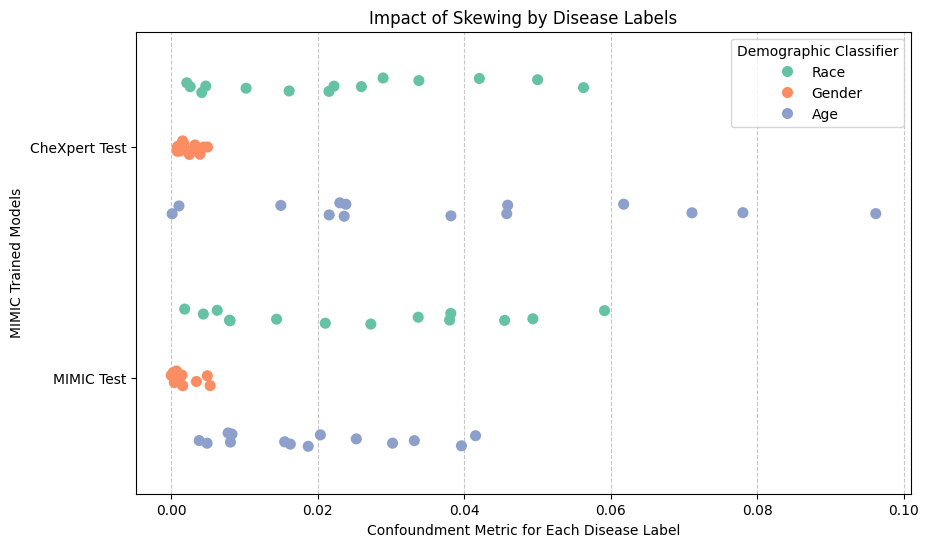

In [ ]:
data = {
    'Model': ['CheXpert Test'] * len(auc_mimic_chex_race) + \
             ['MIMIC Test'] * len(auc_mimic_mimic_race) + \
             ['CheXpert Test'] * len(auc_mimic_chex_gender) + \
             ['MIMIC Test'] * len(auc_mimic_mimic_gender) + \
             ['CheXpert Test'] * len(auc_mimic_chex_age) + \
             ['MIMIC Test'] * len(auc_mimic_mimic_age),

    'AUC': auc_mimic_chex_race + auc_mimic_mimic_race + \
           auc_mimic_chex_gender + auc_mimic_mimic_gender + \
           auc_mimic_chex_age + auc_mimic_mimic_age,

    'Category': ['Race'] * (len(auc_mimic_chex_race) + len(auc_mimic_mimic_race)) + \
                ['Gender'] * (len(auc_mimic_chex_gender) + len(auc_mimic_mimic_gender)) + \
                ['Age'] * (len(auc_mimic_chex_age) + len(auc_mimic_mimic_age))
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create scatter plot using Seaborn, hue to group by Category
plt.figure(figsize=(10, 6))
sns.stripplot(x='AUC', y='Model', hue='Category', data=df, jitter=True, palette='Set2', size=8, dodge=True)

# Adding labels and title
plt.title("Impact of Skewing by Disease Labels")
plt.xlabel("Confoundment Metric for Each Disease Label")
plt.ylabel("MIMIC Trained Models")

# Display the plot with grid lines
plt.legend(loc=1)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.legend(title="Demographic Classifier")
plt.show()

**Illustrative Examples from the MIMIC Models Applied to CheXpert**

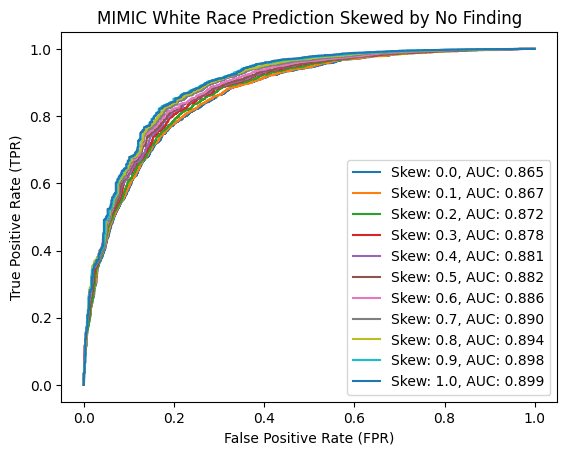

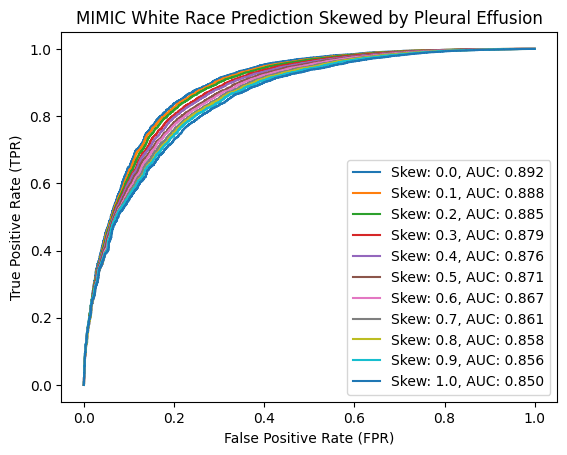

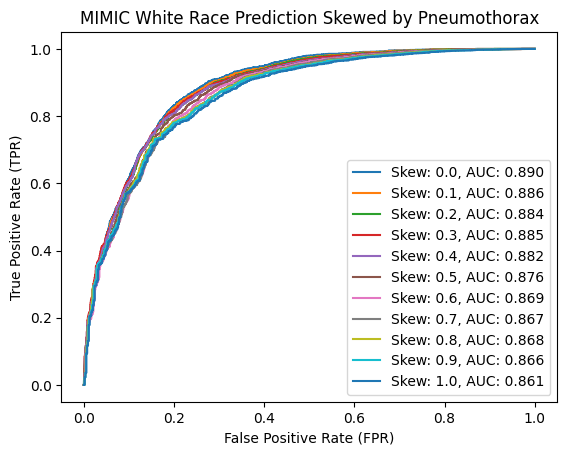

In [ ]:
df = pd.read_csv('/content/mimic_race_chexpert_race_v1_test.csv')
df['Path'] = df['Path'].str.replace('content/s3/CheXpert/', '', regex=False)
train_labels = pd.read_csv('/content/train.csv')
train_labels['Path'] = train_labels['Path'].str.replace("CheXpert-v1.0-small", "CheXpert-v1.0", regex=False)
val_labels = pd.read_csv('/content/valid.csv')
val_labels['Path'] = val_labels['Path'].str.replace("CheXpert-v1.0-small", "CheXpert-v1.0", regex=False)
labels_df = pd.concat([train_labels, val_labels], axis=0)
labels_df.reset_index(drop=True, inplace=True)
labels_df.fillna(0, inplace=True)
labels_df.replace(-1, 0, inplace=True)
df = pd.merge(df, labels_df, on='Path')
df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.rstrip(']')
df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.lstrip('[')
df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].apply(np.fromstring, sep=',', dtype = float)
disease_labels = ['No Finding', 'Pleural Effusion', 'Pneumothorax']
for disease_label in disease_labels:
  white_df, nonwhite_df = binarize_by_race(df)
  #Create 11 biased dataframes with bias ranging from 0 to 1
  biased_test_list = []
  for i in range(0,11):
      bias = float(i/10)
      biased_df = create_disease_biased_test_set(white_df, nonwhite_df, bias, disease_label)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_df['Race/Ethnicity'],y_score = [prob[4] for prob in biased_df['Race/Ethnicity_Probability']], pos_label = 'Non-Hispanic White')
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('MIMIC White Race Prediction Skewed by ' + disease_label)
  # Show the plot
  plt.show()

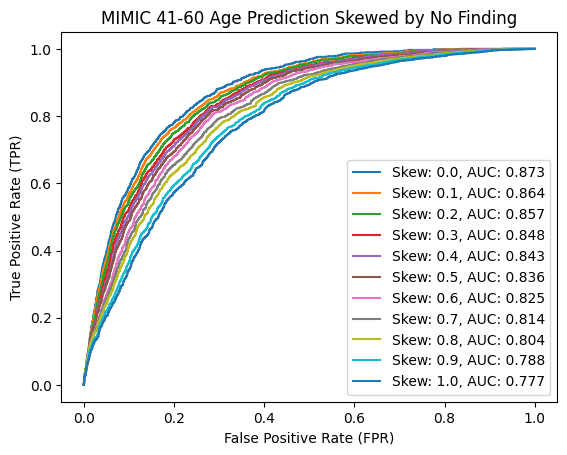

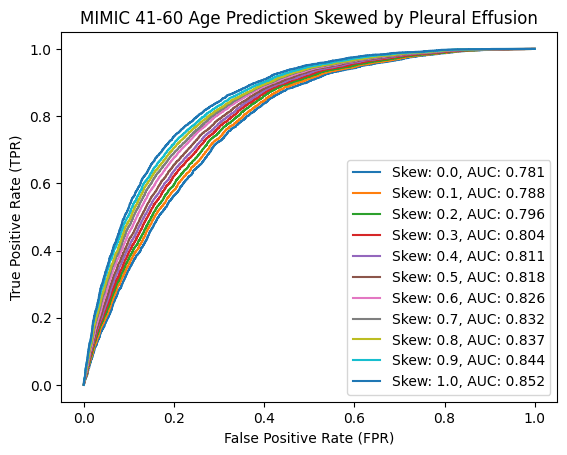

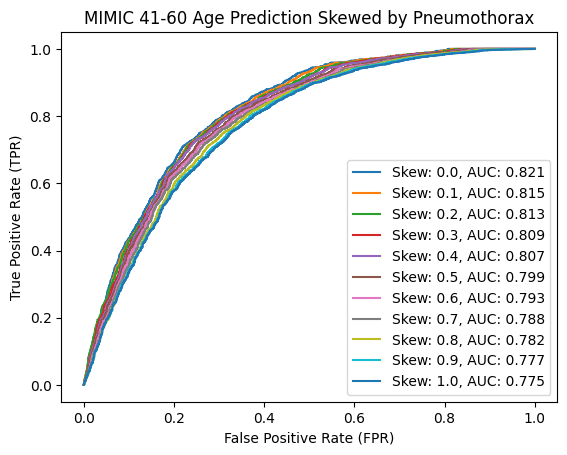

In [ ]:
df = pd.read_csv('/content/mimic_age_chexpert_test.csv')
df['Path'] = df['Path'].str.replace('content/s3/CheXpert/', '', regex=False)
train_labels = pd.read_csv('/content/train.csv')
train_labels['Path'] = train_labels['Path'].str.replace("CheXpert-v1.0-small", "CheXpert-v1.0", regex=False)
val_labels = pd.read_csv('/content/valid.csv')
val_labels['Path'] = val_labels['Path'].str.replace("CheXpert-v1.0-small", "CheXpert-v1.0", regex=False)
labels_df = pd.concat([train_labels, val_labels], axis=0)
labels_df.reset_index(drop=True, inplace=True)
labels_df.fillna(0, inplace=True)
labels_df.replace(-1, 0, inplace=True)
df = pd.merge(df, labels_df, on='Path')
df['Age_Probability'] = df['Age_Probability'].str.rstrip(']')
df['Age_Probability'] = df['Age_Probability'].str.lstrip('[')
df['Age_Probability'] = df['Age_Probability'].apply(np.fromstring, sep=',', dtype = float)
disease_labels = ['No Finding', 'Pleural Effusion', 'Pneumothorax']
for disease_label in disease_labels:
  white_df, nonwhite_df = binarize_by_age(df)
  #Create 11 biased dataframes with bias ranging from 0 to 1
  biased_test_list = []
  for i in range(0,11):
      bias = float(i/10)
      biased_df = create_disease_biased_test_set(white_df, nonwhite_df, bias, disease_label)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_df['Patient Age Category'],y_score = [prob[2] for prob in biased_df['Age_Probability']], pos_label = 2)
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('MIMIC 41-60 Age Prediction Skewed by ' + disease_label)
  # Show the plot
  plt.show()